In [103]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Initialize the QEC code that will be used

ic| nsq: 82, ndq: 81


Rate of non-trivial cases: 100.00%


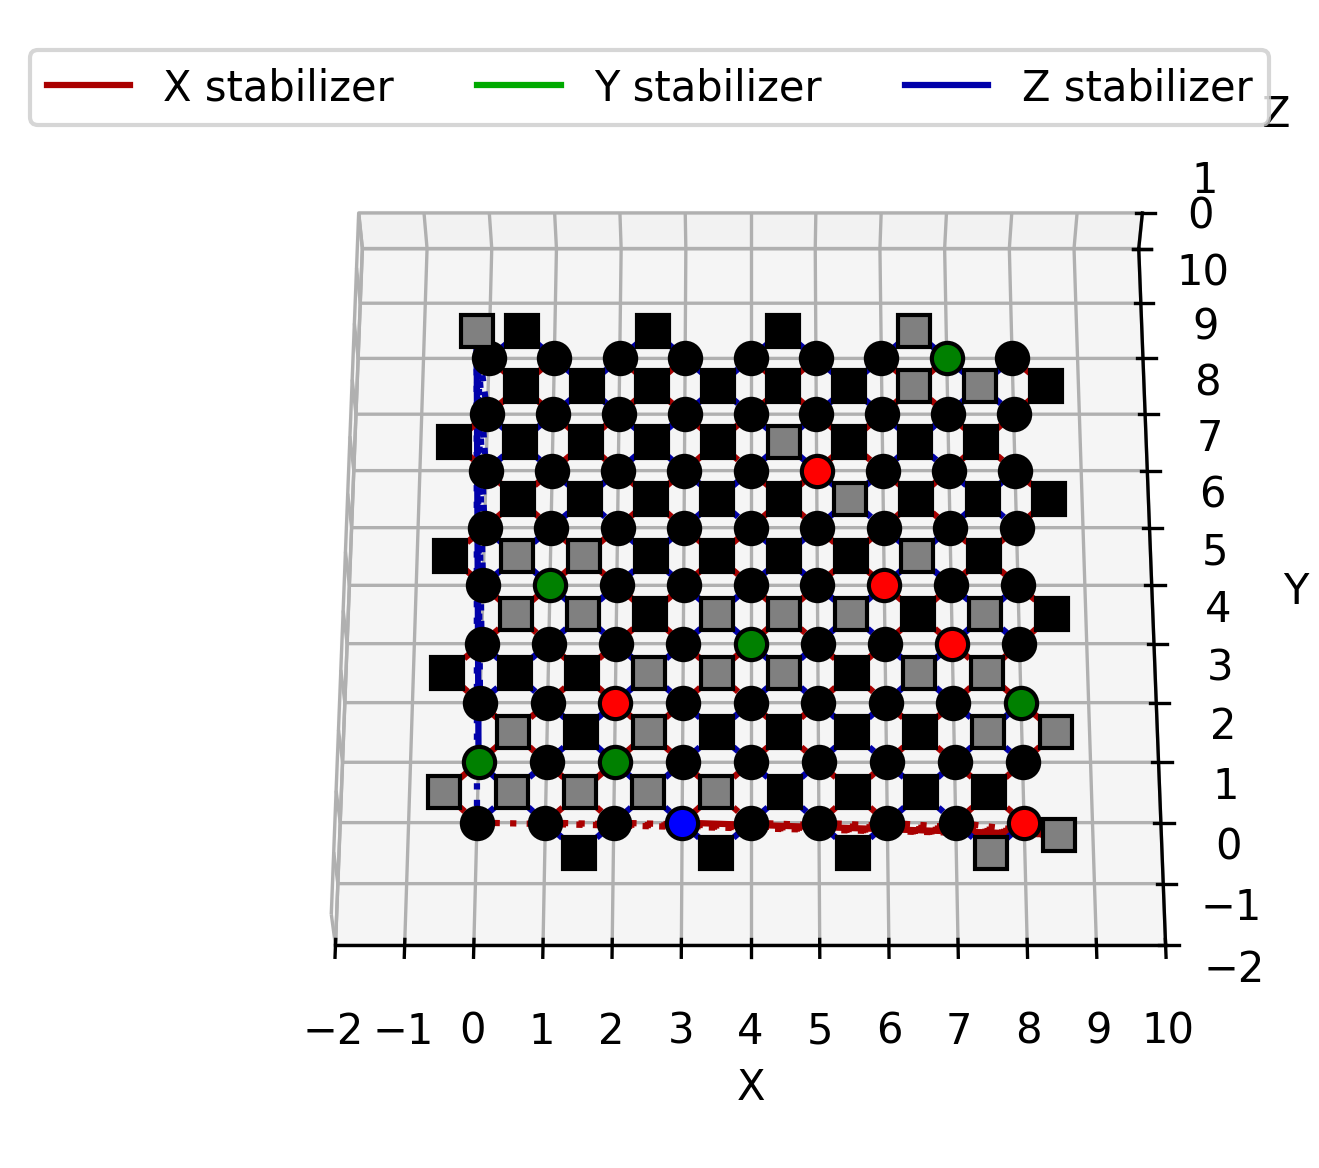

In [119]:
error_prob = [.05, .05, .05]
code_distance = 9

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=1, key=subkey)

qec = QEC(surface_code_data_wls(d=code_distance))
Mx, My, Mz = qec.transformation_matrix()
nsq, ndq = Mx.shape
ic(nsq, ndq)
qec.show(errors=errors[0]);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

# Create a wrapper for the pymatching decoder

In [120]:
def mwpm_prediction(syndromes: jnp.ndarray, Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the implementation of minimum weight perfect matching (MWPM) algorithm using ``pymatching``
    """
    check_matrix = jnp.append(Mx, Mz, axis=1)
    matching = Matching(check_matrix)

    recovery = matching.decode(syndromes)
    d = recovery.shape[0] // 2
    rec_x, rec_z = recovery[:d], recovery[d:]
    return jnp.where(rec_x, jnp.where(rec_z, 2, 1), jnp.where(rec_z, 3, 0))

mwpm_prediction_batch = lambda syndromes, Mx, My, Mz: jnp.array([mwpm_prediction(syndrome, Mx, My, Mz) for syndrome in syndromes])

# View the results

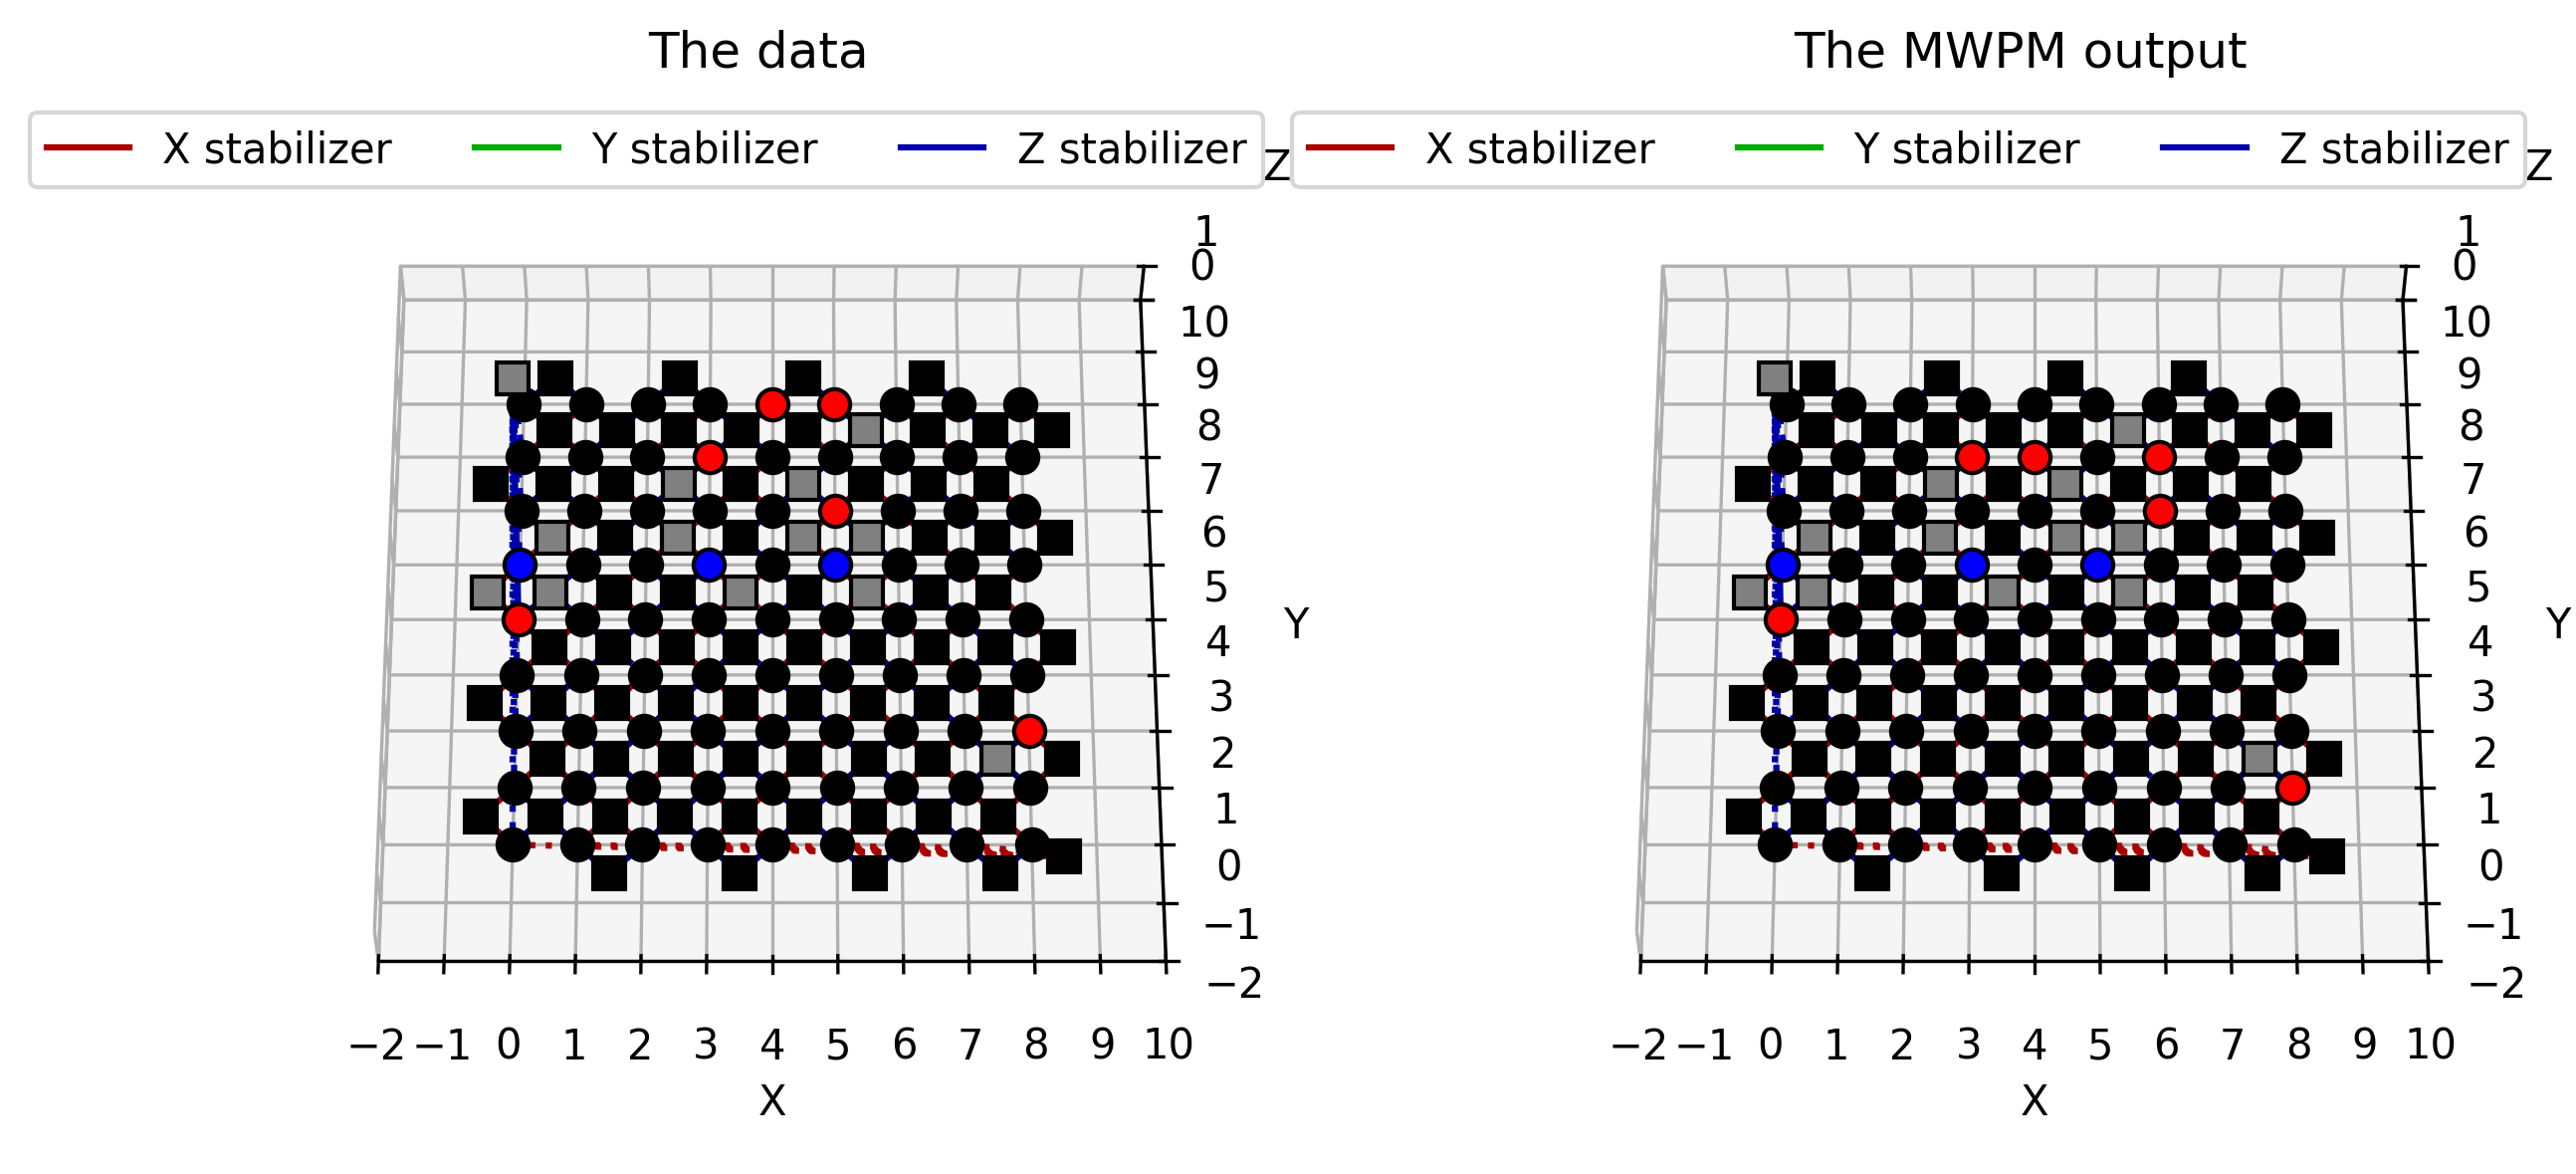

In [125]:
# Generate data
batch_size = 1
subkey, key = jax.random.split(key)
errors = jax_create_error_batch(
    px = error_prob[0],
    py = error_prob[1],
    pz = error_prob[2],
    size = ndq,
    batch_size = batch_size,
    key = subkey
)
syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)

# Run the mwpm
mwpm_correction = mwpm_prediction_batch(syndromes, Mx, My, Mz)

# Show the results
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': '3d'}, dpi=300)
fig.set_figwidth(10)
fig.set_figheight(10)
qec.show(axis=ax1, errors=errors[0], title="The data")
qec.show(axis=ax2, errors=mwpm_correction[0], title="The MWPM output")
plt.show()

In [124]:
%timeit mwpm_prediction(syndromes[0], Mx, My, Mz);

818 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
